# Chess.com Data Analysis

In February of 2021 at the height of Covid lockdowns, I started playing chess on Chess.com.  I had played as a kid and I knew how the pieces each moved, but other than that I had essentially no knowledge of the game.  With nothing better to do I started playing with my brothers and friends over FaceTime, and chess quickly became one of my favorite hobbies.  Today I am still a novice at the game, but one day I want to earn a FIDE master title.  In this project I will review my history of games on chess.com to disover which areas of my game need the most improvement.

The highest ranked title a chess master can reach is 'Grandmaster' and is reached around 2500 elo after beating three players who already have the title in tournaments with strict rules.  Currently there are only around 2,000 people with the Grandmaster title and achieving that rank is nearly impossible, but the Candidate Master title only has a rating requirenment of 2,000+ fide elo. This seems much more attainable!  I have never played in a rated live game before so I am currently unranked, but many form posts on chess.com suggest fide ranks are around 200 points behind online ratings, so my fide elo should be around a 1450.  Gaining 550 elo is not an easy task and it will take years if I want to accomplish this goal, so I should start by improving the weakest parts of my game.  The questions I asked are designed to uncover my biggest flaws.

Questions (rapid only, unless stated otherwise):
1. How many games do I have for each time class?
2. How has my rating changed over time for each time class?
3. How succesful are my favorite openings? What about for 1500+ games?
4. Do I perform worse on games with unorthodox openings?
5. By what method do I win most of my games?
6. By what method do I draw most of my games
7. By what method do I lose most of my games?
8. Where do I spend most of my time?
9. How many moves do my games last?
10. Does castling impact my success rate?

All the data was taken from my profile through the the Chess.com api. For more information, go to https://www.chess.com/forum/view/community/chess-com-api

## Install Packages

In [1]:
!pip install pandas
# !pip install chess.com


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: C:\Users\ck\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
# from chessdotcom import get_player_profile
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
from datetime import datetime
import json
from tqdm import tqdm
import math
from bs4 import BeautifulSoup 
import html5lib

## Data Pre Processing

In [3]:
username = 'Spicy_Chris'
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
pd.set_option('display.max_columns', None)

#### Gather Data

In [4]:
stats_url = f"https://api.chess.com/pub/player/{username}/stats"
player_stats = requests.get(stats_url, headers=headers).json()

In [5]:
# Get all games since creation date and save to pd dataframe
all_games = []
todays_date = datetime.now()
monthly_data_urls = requests.get(f"https://api.chess.com/pub/player/{username}/games/archives", headers=headers).json()['archives']
for url in tqdm(monthly_data_urls, position=0, leave=True):
    games = requests.get(url, headers=headers).json()['games']        
    all_games += games
print(f"Found {len(all_games)} Games")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:28<00:00,  1.23it/s]

Found 6378 Games


In [6]:
# Build df
df = pd.DataFrame.from_dict(all_games, orient='columns')
df.head(1)

,url,pgn,time_control,end_time,rated,accuracies,tcn,uuid,initial_setup,fen,time_class,rules,white,black,tournament,start_time
0,https://www.chess.com/game/live/8717136503,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",600,1614978232,True,"{'white': 13.815347900907305, 'black': 49.7934...",gv0KmC5Qbs!TltZJcMJCtC9zMT7TfH8!eg2UpFQBsJBvov...,c5f9483e-7df5-11eb-bd8a-536974010001,rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...,2r2r2/pp4kp/2p3p1/1B2pp2/1b2P2Q/8/PPP2P2/R4RK1...,rapid,chess,"{'rating': 981, 'result': 'win', '@id': 'https...","{'rating': 792, 'result': 'resigned', '@id': '...",NaN,NaN


#### Clean Data

In [7]:
# Remove non-traditional games (Fischer random, bughouse, chess960, ...)
df = df.query("rules == 'chess'")
df = df.rename(columns={"start_time": "start_time_utx", "end_time": "end_time_utx"})

In [8]:
# Pull the important information out of the pgn column and return it in a dict
def pgn_to_dict(pgn) -> dict:
    pgn_data = {}
    idx_to_col = {
        2: 'start_date',
        6: 'result',
        9: 'ECO',
        16: 'termination',
        17: 'start_time',
        18: 'end_date',
        19: 'end_time',
        22: 'moves'
    }
    
    for i, row in enumerate(pgn.split('\n')):
        if i in idx_to_col.keys():
            if i == 22:
                pgn_data[idx_to_col[i]] = row
            else:
                data = row.split("\"")[1]
                pgn_data[idx_to_col[i]] = data
    return pgn_data

In [9]:
# Turn the string of pgn moves into a json format
def game_notation_to_json(moves):
    moves_json = {}
    for i, line in enumerate(moves.split(']} ')):
        if i+1 == len(moves.split(']}')):
            break
            
        w_or_b = 'white' if i % 2 == 0 else 'black'
        move_no, move, clock = line.replace('{[%clk ', '').replace('..', '').replace('. ', ' ').split(' ')
        move_no = int(move_no)
        ply_data = {'move': move, 'clock': clock}
                
        if move_no not in moves_json.keys():
            moves_json[move_no] = { 'white': {'move': None, 'clock': None},
                                    'black': {'move': None, 'clock': None}, }
                
        moves_json[move_no][w_or_b] = ply_data
    return moves_json

In [10]:
# Web scrape openings and their eco codes
eco_codes = {}
eco_url = "https://www.chessgames.com/chessecohelp.html"
eco_response = requests.get(eco_url, headers=headers)

soup = BeautifulSoup(eco_response.content, "html.parser")
for row in soup.find_all('tr'):
    eco = row.find_all('td')[0].get_text()
    opening_data = row.find_all('td')[1].get_text().split('\n')
    eco_codes[eco] = opening_data

In [11]:
# Expand all nested data data on one row
for index, row in tqdm(df.iterrows(), position=0, leave=True):
    # Expand accuracies column
    w_accuracy = None
    b_accuracy = None
    
    # If the game was analyzed, add accuracies
    if type(row['accuracies']) != float:
        w_accuracy = row['accuracies']['white']
        b_accuracy = row['accuracies']['black']
    
    if row['white']['username'] == username:
        df.at[index, 'my_accuracy'] = w_accuracy
        df.at[index, 'my_rating'] = row['white']['rating']
        df.at[index, 'my_result'] = row['white']['result']
        df.at[index, 'my_username'] = row['white']['username']
        df.at[index, 'my_color'] = 'white'

        df.at[index, 'opponent_accuracy'] = b_accuracy
        df.at[index, 'opponent_rating'] = row['black']['rating']
        df.at[index, 'opponent_result'] = row['black']['result']
        df.at[index, 'opponent_username'] = row['black']['username']
        df.at[index, 'opponent_color'] = 'black'
    
    elif row['black']['username'] == username:
        df.at[index, 'opponent_accuracy'] = w_accuracy
        df.at[index, 'opponent_rating'] = row['white']['rating']
        df.at[index, 'opponent_result'] = row['white']['result']
        df.at[index, 'opponent_username'] = row['white']['username']
        df.at[index, 'opponent_color'] = 'white'

        df.at[index, 'my_accuracy'] = b_accuracy
        df.at[index, 'my_rating'] = row['black']['rating']
        df.at[index, 'my_result'] = row['black']['result']
        df.at[index, 'my_username'] = row['black']['username']
        df.at[index, 'my_color'] = 'black'
    else:
        print(f"Username mismatch: {index}")
        continue
    
    # Expand pgn column
    pgn_data = pgn_to_dict(row['pgn'])
    for col_name, pgn_row in pgn_data.items():
        df.at[index, col_name] = pgn_row
    
    # Expand moves column
    moves_json = game_notation_to_json(pgn_data['moves'])
    
    # Check the game has move history
    if len(moves_json) > 0:
        df.at[index, 'moves'] = moves_json
        df.at[index, 'opening'] = eco_codes[df.at[index, 'ECO']][0]
        df.at[index, 'opening_moves'] = eco_codes[df.at[index, 'ECO']][1]
        ply = int(len(moves_json) * 2 - 1) if moves_json[len(moves_json)]['black']['move'] == None else int(len(moves_json) * 2)
        df.at[index, 'ply'] = int(ply)


6373it [00:05, 1236.52it/s]


In [12]:
# Remove old / unwanted columns
df = df.drop(columns=['accuracies', 'black', 'white', 'pgn', 'initial_setup'], axis=1)
df = df.query("time_class != 'daily'")

In [13]:
# Order by date
df.sort_values('end_time_utx')
df.head()

,url,time_control,end_time_utx,rated,tcn,uuid,fen,time_class,rules,tournament,start_time_utx,my_accuracy,my_rating,my_result,my_username,my_color,opponent_accuracy,opponent_rating,opponent_result,opponent_username,opponent_color,start_date,result,ECO,termination,start_time,end_date,end_time,moves,opening,opening_moves,ply
0,https://www.chess.com/game/live/8717136503,600,1614978232,True,gv0KmC5Qbs!TltZJcMJCtC9zMT7TfH8!eg2UpFQBsJBvov...,c5f9483e-7df5-11eb-bd8a-536974010001,2r2r2/pp4kp/2p3p1/1B2pp2/1b2P2Q/8/PPP2P2/R4RK1...,rapid,chess,NaN,NaN,13.815348,981.0,win,Spicy_Chris,white,49.793494,792.0,resigned,rigbl,black,2021.03.05,1-0,C40,Spicy_Chris won by resignation,21:00:09,2021.03.05,21:03:52,"{1: {'white': {'move': 'Nf3', 'clock': '0:10:0...",King's Knight Opening,1 e4 e5 2 Nf3,40.0
1,https://www.chess.com/game/live/8717206583,600,1614978702,True,mC5Qbs0KfH9Igv2MvM7MltMohfInfnonenZRsJ45ne3NkA...,4d83ec20-7df6-11eb-bd8a-536974010001,3Q4/2p2p2/p1ppk3/4p1rp/2P1P1b1/3P4/PP5P/R3K3 w...,rapid,chess,NaN,NaN,NaN,865.0,resigned,Spicy_Chris,black,NaN,1015.0,win,Shelykoopa,white,2021.03.05,1-0,C25,Shelykoopa won by resignation,21:03:58,2021.03.05,21:11:42,"{1: {'white': {'move': 'e4', 'clock': '0:09:58...",Vienna,1 e4 e5 2 Nc3,42.0
2,https://www.chess.com/game/live/8717765217,600,1614979745,True,gvZJbs!Tmu0SfHYQHt9ziqzsls8!vK5ZnDQItHWOHZ6Zeg...,63aeb534-7df7-11eb-bd8a-536974010001,1Q4k1/8/p3p1K1/1P1pPrp1/8/2P1P3/2P5/R1B4r b - -,rapid,chess,NaN,NaN,30.849567,956.0,win,Spicy_Chris,white,38.304636,817.0,timeout,josiefa,black,2021.03.05,1-0,A06,Spicy_Chris won on time,21:11:41,2021.03.05,21:29:05,"{1: {'white': {'move': 'Nf3', 'clock': '0:10:0...",Reti Opening,1 Nf3 d5,75.0
3,https://www.chess.com/game/live/8932634011,300,1615194322,True,mC5QgvZJCJ7JbsJSfmXPvMSLlB0KmA6SBJ3VMvKCvFLEJS...,3a105422-7fec-11eb-968e-536974010001,4Q3/pkp1R3/1pn3rB/8/8/1P6/P1P2PqP/5RK1 w - -,blitz,chess,NaN,NaN,14.971387,965.0,win,Spicy_Chris,black,34.754114,767.0,checkmated,liptondavid,white,2021.03.08,0-1,B00,Spicy_Chris won by checkmate,08:56:53,2021.03.08,09:05:22,"{1: {'white': {'move': 'e4', 'clock': '0:05:00...",Uncommon King's Pawn Opening,1 e4,56.0
4,https://www.chess.com/game/live/8933228327,600,1615194896,True,gvYImuZJks2UfH6ZdyWOvK!THZTZKZ5ZlBIAjzXHyGZPnv...,886020b1-7fed-11eb-968e-536974010001,4kR1r/r3p2p/p5p1/4q1B1/1Pp1p3/2n5/P5PP/R3K3 b ...,rapid,chess,NaN,NaN,NaN,864.0,resigned,Spicy_Chris,white,NaN,901.0,win,DanieloLeFicelo,black,2021.03.08,0-1,A04,DanieloLeFicelo won by resignation,09:06:17,2021.03.08,09:14:56,"{1: {'white': {'move': 'Nf3', 'clock': '0:10:0...",Reti Opening,1 Nf3,41.0


## Analysis

In [14]:
profile_url = f"https://api.chess.com/pub/player/{username}"
profile_data = requests.get(profile_url, headers=headers).json()
join_date_utx = profile_data['joined']
join_date = datetime.fromtimestamp(join_date_utx)
print("Account creation date: ", join_date)

Account creation date:  2021-02-28 04:46:42


In [15]:
win_conditions = ['win']
draw_conditions = ['stalemate', 'agreed', 'insufficient', 'repetition', '50move', 'timevsinsufficient']
loss_conditions = ['resigned', 'abandoned', 'timeout', 'checkmated']

### 1. How many games do I have for each time class?

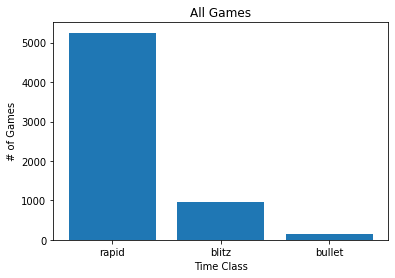

In [16]:
x = []
labels = []
for time_class in df['time_class'].unique():
    query_result = df.query(f"time_class == '{time_class}'")
    x.append(len(query_result))
    labels.append(time_class)

plt.bar(labels, x)
plt.xlabel('Time Class')
plt.ylabel('# of Games')
plt.title('All Games')
plt.show()

### 2. How has my rating changed over time for each time class?

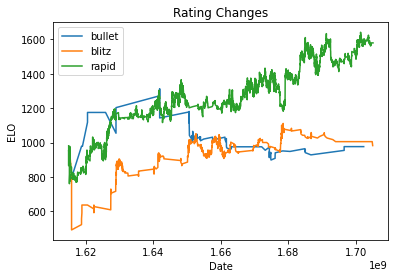

In [17]:
time_class_query = lambda time_class: f"time_class == '{time_class}'"
time_classes = {'chess_bullet': 'bullet', 'chess_blitz': 'blitz', 'chess_rapid': 'rapid'}

for k, v in time_classes.items():
    games = df.query(time_class_query(v))
    games.head()
    games.sort_values('end_time_utx')
    ratings = []
    dates = []
    
    for idx, game in games.iterrows():
        rating = game['my_rating']
        date = game['end_time_utx']
        ratings.append(rating)
        dates.append(date)
        
    plt.plot(dates, ratings, label=v)

    
plt.legend(loc="upper left")
plt.xlabel('Date')
plt.ylabel('ELO')
plt.title('Rating Changes')
plt.show()

### 3. How  succesful are my favorite openings? What about for 1500+ games?

In [18]:
# Note: From this point on all questions are focused only on rapid games
df_rapid = df.query("time_class == 'rapid'")

In [19]:
games_won = df_rapid.query(f"my_result in {win_conditions}")
games_drawn = df_rapid.query(f"my_result in {draw_conditions}")
games_lost = df_rapid.query(f"my_result in {loss_conditions}")

In [20]:
def get_opening_success_rates(color, dataset):
    wins = []
    draws = []
    losses = []
    labels = []
    totals = []
    color_games = dataset.query(f"my_color == '{color}'")
    
    if len(color_games) == 0:
        return []
    
    for opening in color_games['opening'].unique():
        opening_games = color_games.query(f"opening == \"{opening}\"")
        wins.append(len(opening_games.query(f"my_result in {win_conditions}")))
        draws.append(len(opening_games.query(f"my_result in {draw_conditions}")))
        losses.append(len(opening_games.query(f"my_result in {loss_conditions}")))
        labels.append(opening)
        totals.append(len(opening_games))
    return sorted(zip(labels, totals, wins, draws, losses), key=lambda x: x[1], reverse=True)

#### White games

In [21]:
w_zipped = get_opening_success_rates('white', df_rapid)
w_labels = [label[0] for label in w_zipped[:10]]
opening_wins = [round(label[2] / (label[2] + label[3] + label[4]), 3) for label in w_zipped[:10]]
opening_draws = [round(label[3] / (label[2] + label[3] + label[4]), 3) for label in w_zipped[:10]]
opening_losses = [round(label[4] / (label[2] + label[3] + label[4]), 3) for label in w_zipped[:10]]

In [22]:
for opening in w_zipped[:10]:
    print(f"{opening[0]} -- {opening[2]} W / {opening[3]} D / {opening[4]} L ({round(opening[2] / opening[1] * 100)}% / {round(opening[3] / opening[1] * 100)}% / {round(opening[4] / opening[1] * 100)}%)")

Queen's Pawn Game -- 390 W / 30 D / 346 L (51% / 4% / 45%)
Queen's Gambit Declined -- 321 W / 25 D / 256 L (53% / 4% / 43%)
Queen's Gambit Accepted -- 183 W / 12 D / 129 L (56% / 4% / 40%)
Queen's Gambit Declined Slav -- 126 W / 7 D / 87 L (57% / 3% / 40%)
King's Indian -- 51 W / 6 D / 43 L (51% / 6% / 43%)
Queen's Gambit Declined, Albin Counter Gambit -- 41 W / 1 D / 40 L (50% / 1% / 49%)
Queen's Pawn Game (with ...d6) -- 33 W / 3 D / 25 L (54% / 5% / 41%)
Old Indian -- 31 W / 5 D / 18 L (57% / 9% / 33%)
Dutch -- 31 W / 2 D / 18 L (61% / 4% / 35%)
Old Benoni -- 14 W / 3 D / 26 L (33% / 7% / 60%)


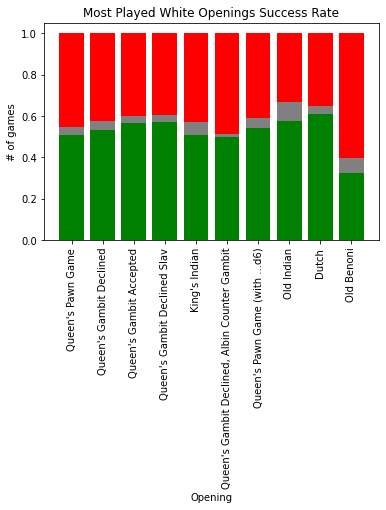

In [23]:
plt.bar(w_labels, opening_wins, color='green')
plt.bar(w_labels, opening_draws, bottom=opening_wins, color='gray')
plt.bar(w_labels, opening_losses, bottom=np.add(opening_wins, opening_draws), color='red')
plt.xlabel('Opening')
plt.ylabel('# of games')
plt.title('Most Played White Openings Success Rate')
plt.xticks(rotation=90)
plt.show()

#### White games > 1500

In [24]:
games_over_1500 = df_rapid.query("opponent_rating >= 1500")

In [25]:
w_zipped_1500 = get_opening_success_rates('white', games_over_1500)
w_labels_1500 = [label[0] for label in w_zipped_1500[:10]]
w_opening_wins_1500 = [round(label[2] / (label[2] + label[3] + label[4]), 3) for label in w_zipped_1500[:10]]
w_opening_draws_1500 = [round(label[3] / (label[2] + label[3] + label[4]), 3) for label in w_zipped_1500[:10]]
w_opening_losses_1500 = [round(label[4] / (label[2] + label[3] + label[4]), 3) for label in w_zipped_1500[:10]]

In [26]:
for opening in w_zipped[:10]:
    print(f"{opening[0]} -- {opening[2]} W / {opening[3]} D / {opening[4]} L ({round(opening[2] / opening[1] * 100)}% / {round(opening[3] / opening[1] * 100)}% / {round(opening[4] / opening[1] * 100)}%)")

Queen's Pawn Game -- 390 W / 30 D / 346 L (51% / 4% / 45%)
Queen's Gambit Declined -- 321 W / 25 D / 256 L (53% / 4% / 43%)
Queen's Gambit Accepted -- 183 W / 12 D / 129 L (56% / 4% / 40%)
Queen's Gambit Declined Slav -- 126 W / 7 D / 87 L (57% / 3% / 40%)
King's Indian -- 51 W / 6 D / 43 L (51% / 6% / 43%)
Queen's Gambit Declined, Albin Counter Gambit -- 41 W / 1 D / 40 L (50% / 1% / 49%)
Queen's Pawn Game (with ...d6) -- 33 W / 3 D / 25 L (54% / 5% / 41%)
Old Indian -- 31 W / 5 D / 18 L (57% / 9% / 33%)
Dutch -- 31 W / 2 D / 18 L (61% / 4% / 35%)
Old Benoni -- 14 W / 3 D / 26 L (33% / 7% / 60%)


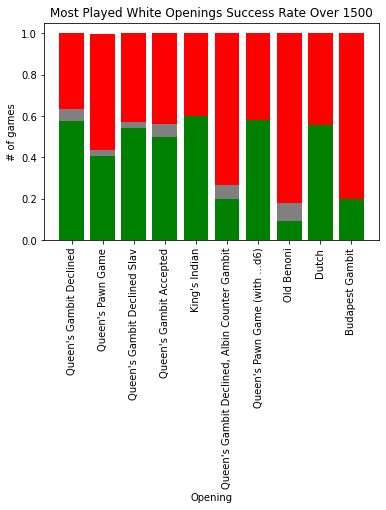

In [27]:
plt.bar(w_labels_1500, w_opening_wins_1500, color='green')
plt.bar(w_labels_1500, w_opening_draws_1500, bottom=w_opening_wins_1500, color='gray')
plt.bar(w_labels_1500, w_opening_losses_1500, bottom=np.add(w_opening_wins_1500, w_opening_draws_1500), color='red')
plt.xlabel('Opening')
plt.ylabel('# of games')
plt.title('Most Played White Openings Success Rate Over 1500')
plt.xticks(rotation=90)
plt.show()

#### Black games

In [28]:
b_zipped = get_opening_success_rates('black', df_rapid)
b_labels = [label[0] for label in b_zipped[:10]]
b_opening_wins = [round(label[2] / (label[2] + label[3] + label[4]), 3)  for label in b_zipped[:10]]
b_opening_draws = [round(label[3] / (label[2] + label[3] + label[4]), 3) for label in b_zipped[:10]]
b_opening_losses = [round(label[4] / (label[2] + label[3] + label[4]), 3) for label in b_zipped[:10]]

In [29]:
for opening in b_zipped[:10]:
    print(f"{opening[0]} -- {opening[2]} W / {opening[3]} D / {opening[4]} L ({round(opening[2] / opening[1] * 100)}% / {round(opening[3] / opening[1] * 100)}% / {round(opening[4] / opening[1] * 100)}%)")

Sicilian -- 266 W / 23 D / 249 L (49% / 4% / 46%)
Queen's Pawn Game -- 221 W / 21 D / 235 L (46% / 4% / 49%)
Giuoco Piano -- 79 W / 6 D / 71 L (51% / 4% / 46%)
Robatsch -- 59 W / 2 D / 60 L (49% / 2% / 50%)
Sicilian, Closed -- 56 W / 4 D / 41 L (55% / 4% / 41%)
Sicilian, 2.f4 and 2.d4 -- 42 W / 8 D / 46 L (44% / 8% / 48%)
Sicilian, Alapin -- 35 W / 6 D / 49 L (39% / 7% / 54%)
Uncommon Opening -- 48 W / 6 D / 35 L (54% / 7% / 39%)
Scandinavian -- 39 W / 2 D / 42 L (47% / 2% / 51%)
Petrov Defense -- 23 W / 5 D / 29 L (40% / 9% / 51%)


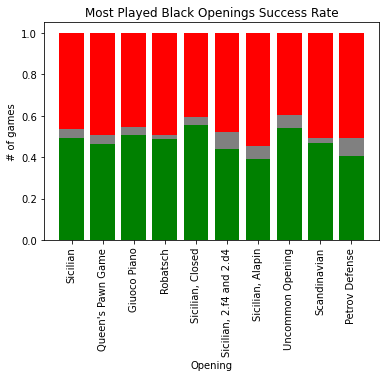

In [30]:
plt.bar(b_labels, b_opening_wins, color='green')
plt.bar(b_labels, b_opening_draws, bottom=b_opening_wins, color='gray')
plt.bar(b_labels, b_opening_losses, bottom=np.add(b_opening_wins, b_opening_draws), color='red')
plt.xlabel('Opening')
plt.ylabel('# of games')
plt.title('Most Played Black Openings Success Rate')
plt.xticks(rotation=90)
plt.show()

#### Black games > 1500

In [31]:
b_zipped_1500 = get_opening_success_rates('black', games_over_1500)
b_labels_1500 = [label[0] for label in b_zipped_1500[:10]]
b_opening_wins_1500 = [round(label[2] / (label[2] + label[3] + label[4]), 3) for label in b_zipped_1500[:10]]
b_opening_draws_1500 = [round(label[3] / (label[2] + label[3] + label[4]), 3) for label in b_zipped_1500[:10]]
b_opening_losses_1500 = [round(label[4] / (label[2] + label[3] + label[4]), 3) for label in b_zipped_1500[:10]]

In [32]:
for opening in b_zipped_1500[:10]:
    print(f"{opening[0]} -- {opening[2]} W / {opening[3]} D / {opening[4]} L ({round(opening[2] / opening[1] * 100)}% / {round(opening[3] / opening[1] * 100)}% / {round(opening[4] / opening[1] * 100)}%)")

Giuoco Piano -- 40 W / 4 D / 40 L (48% / 5% / 48%)
Queen's Pawn Game -- 17 W / 2 D / 35 L (31% / 4% / 65%)
Scotch Game -- 3 W / 2 D / 14 L (16% / 11% / 74%)
King's Pawn Game -- 12 W / 0 D / 6 L (67% / 0% / 33%)
Vienna -- 8 W / 0 D / 8 L (50% / 0% / 50%)
King's Indian -- 6 W / 1 D / 9 L (38% / 6% / 56%)
King's Gambit Declined -- 4 W / 1 D / 11 L (25% / 6% / 69%)
Bishop's Opening -- 2 W / 1 D / 9 L (17% / 8% / 75%)
Three Knights -- 4 W / 1 D / 6 L (36% / 9% / 55%)
Ruy Lopez -- 3 W / 0 D / 7 L (30% / 0% / 70%)


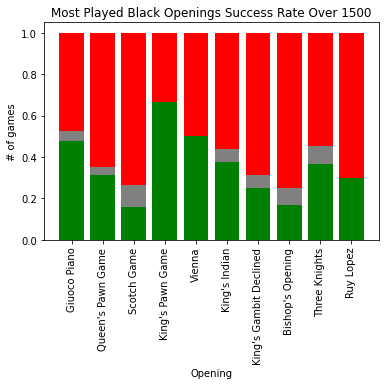

In [33]:
plt.bar(b_labels_1500, b_opening_wins_1500, color='green')
plt.bar(b_labels_1500, b_opening_draws_1500, bottom=b_opening_wins_1500, color='gray')
plt.bar(b_labels_1500, b_opening_losses_1500, bottom=np.add(b_opening_wins_1500, b_opening_draws_1500), color='red')
plt.xlabel('Opening')
plt.ylabel('# of games')
plt.title('Most Played Black Openings Success Rate Over 1500')
plt.xticks(rotation=90)
plt.show()

###  4. Do I perform worse on games with unorthodox openings?

In [34]:
max_games = 20
total_wins = 0
total_games = 0
total_draws = 0
total_losses = 0
for opening in w_zipped + b_zipped:
    if opening[1] < max_games:
        total_games += opening[1]
        total_wins += opening[2]
        total_draws += opening[3]
        total_losses += opening[4]
        
print(f"Sum of uncommon openings (<{max_games} games):")
print(f"Total games: {total_games}")
print(f"{round(total_wins / (total_games) * 100, 2)}% Wins / {round(total_draws / total_games * 100, 2)}% Draws / {round(total_losses / total_games * 100, 2)}% Losses")


Sum of uncommon openings (<20 games):
Total games: 519
43.93% Wins / 4.05% Draws / 52.02% Losses


### 5. By what method do I win most of my games?

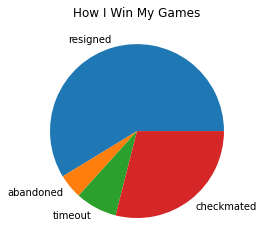

In [35]:
x = []
for condition in loss_conditions:
    x.append(len(df_rapid.query(f"opponent_result == '{condition}'")))
plt.pie(x=x, labels=loss_conditions)
plt.title('How I Win My Games')
plt.show()

### 6. By what method do I draw most of my games

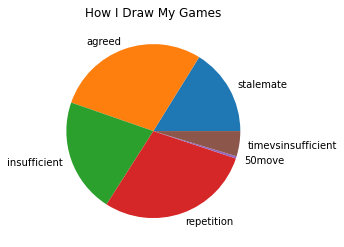

In [36]:
x = []
for condition in draw_conditions:
    x.append(len(df_rapid.query(f"my_result == '{condition}'")))
plt.pie(x=x, labels=draw_conditions)
plt.title('How I Draw My Games')
plt.show()

### 7. By what method do I lose most of my games?

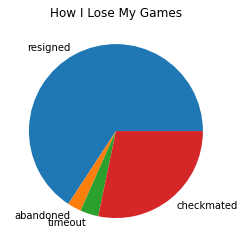

In [37]:
x = []
for condition in loss_conditions:
    x.append(len(df_rapid.query(f"my_result == '{condition}'")))
plt.pie(x=x, labels=loss_conditions)
plt.title('How I Lose My Games')
plt.show()

### 8. Where do I spend most of my time?

In [38]:
# %H:%M:%S: -> seconds
def get_total_seconds(stringHMS):
    ms = 0.0
    if '.' in stringHMS:
        stringHMS, ms = stringHMS.split('.')
        ms = round(float(ms) / 10, 1)
    timedeltaObj = datetime.strptime(stringHMS.split('.')[0], "%H:%M:%S") - datetime(1900,1,1) 
    return float(timedeltaObj.total_seconds()) + ms

In [39]:
times_per_move = {}
for _, game in tqdm(df_rapid.iterrows()):
    if type(game['moves']) == str:
        continue
         
     # Check if there is a time increment
    time_increment = 0 
    previous_time = float(game['time_control'].split('+')[0])
    if '+' in game['time_control']:
        time_increment = int(game['time_control'].split('+')[1])
           
    for move_no in game['moves'].keys():
        try:
            # Skip moves that timed out before being completed
            if game['moves'][move_no][game['my_color']]['clock'] == None:
                continue
            current_time = get_total_seconds(game['moves'][move_no][game['my_color']]['clock'])
            time_taken = round(previous_time - current_time + time_increment, 1)
            if move_no not in times_per_move.keys():
                times_per_move[move_no] = []
            times_per_move[move_no].append(time_taken)
            previous_time = current_time
        except:
            print('Error with game: ', game['moves'])
            continue

5252it [00:04, 1124.92it/s]


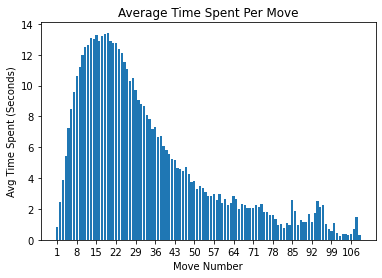

In [41]:
avg_time_per_move = {}
x = []
y = []
for move_no, move_times in times_per_move.items():
    avg_move_time = sum(move_times) / len(move_times)
    x.append(move_no)
    y.append(avg_move_time)
plt.bar(x, y)
plt.xlabel('Move Number')
plt.ylabel('Avg Time Spent (Seconds)')
plt.title('Average Time Spent Per Move')
plt.xticks(np.arange(1, x[-1], 7))
plt.show()  # Some times can be negative when playing with an interval

### 9. How many moves do my games last?

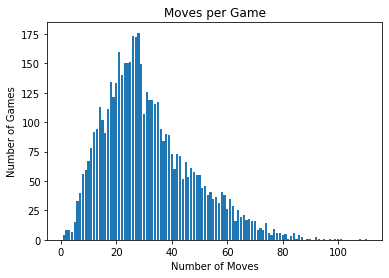

In [42]:
labels = [i+1 for i in range(int(-(-max(df_rapid['ply']) // 2)))]
num_games = [0] * len(labels)

for ply in df_rapid['ply']:
    if math.isnan(ply):
        continue
    num_games[int(-(-ply//2))-1] += 1
plt.bar(labels, num_games)
plt.title('Moves per Game')
plt.xlabel('Number of Moves')
plt.ylabel('Number of Games')
plt.show()

### 10. Does castling impact my success rate? Show success rate for:
    1. No castle
    2. Short castle
    3. Long castle
    4. Castle before (or on) move 10
    5. Castle after move 10

In [43]:
castle_success_rates = {
    'No Castle': {
        'wins': 0,
        'losses': 0,
        'draws': 0,
    },
    'Castled By Move 10': {
        'wins': 0,
        'losses': 0,
        'draws': 0,
    },
    'Castled After Move 10': {
        'wins': 0,
        'losses': 0,
        'draws': 0,
    },
    'Short Castle': {
        'wins': 0,
        'losses': 0,
        'draws': 0,
    },
    'Long Castle': {
        'wins': 0,
        'losses': 0,
        'draws': 0,
    }
}


In [44]:
def check_result(my_result, category):
    if my_result in win_conditions:
        category['wins'] += 1
    elif my_result in draw_conditions:
        category['draws'] += 1
    elif my_result in loss_conditions:
        category['losses'] += 1
    return category

In [45]:
# gather the total number of wins, draws, and losses for each castling option
for index, game in df_rapid.iterrows():
    if type(game['moves']) == str:
        continue
    
    castled = False
    short_long_castle = None
    castled_move = -1
    
    # Check which category each game falls into
    for move_no in game['moves'].keys():
        if game['moves'][move_no][game['my_color']]['move'] == None:
            continue
        if 'O' in game['moves'][move_no][game['my_color']]['move']:
            castled = True
            castled_move = move_no
            if 'O-O-O' in game['moves'][move_no][game['my_color']]['move']:
                short_long_castle = 'long'
            elif 'O-O' in game['moves'][move_no][game['my_color']]['move']:
                short_long_castle = 'short'
            break
    
    # Not castled data
    if not castled:
        castle_success_rates['No Castle'] = check_result(game['my_result'], castle_success_rates['No Castle'])
    
    else:
        # Pre 10 data
        if castled_move > 0 and castled_move <= 10:
            castle_success_rates['Castled By Move 10'] = check_result(game['my_result'], castle_success_rates['Castled By Move 10'])
        
        # Post 10 data
        elif castled_move > 10:
            castle_success_rates['Castled After Move 10'] = check_result(game['my_result'], castle_success_rates['Castled After Move 10'])
                
        # Short castle data
        if short_long_castle == 'short':
            castle_success_rates['Short Castle'] = check_result(game['my_result'], castle_success_rates['Short Castle'])
                
        # Long castle data
        elif short_long_castle == 'long':
            castle_success_rates['Long Castle'] = check_result(game['my_result'], castle_success_rates['Long Castle'])


In [46]:
# Turn wins from totals to percentages
for line in castle_success_rates.keys():
    total_games = castle_success_rates[line]['wins'] + castle_success_rates[line]['draws'] + castle_success_rates[line]['losses']
    castle_success_rates[line]['wins'] = castle_success_rates[line]['wins'] / total_games
    castle_success_rates[line]['losses'] = castle_success_rates[line]['losses'] / total_games
    castle_success_rates[line]['draws'] = castle_success_rates[line]['draws'] / total_games


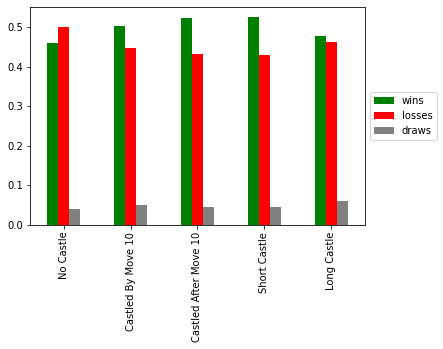

In [47]:
pd.DataFrame(castle_success_rates).transpose().plot(kind="bar", color=['g', 'r', 'gray'], stacked=False)
ax = plt.subplot(111)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## Conclusions

From analysing my past games, I learned that my blitz rating frequently fluctuates by over 100 points, but tends to increase in the long run.  This is likely due to a combination of matchmaking luck, and variance in my focus when playing. I can see that my skill level has increased by ~800 elo in the past couple years, but I have been struggling for the past 6 months to break 1650.  I mostly learn by reviewing my games immediately after playing them to see what I did well and where I messed up.  I do not spend much time looking at opening theory, and I only do puzzles a couple times a month.  Chess masters use these tactics daily to study, so I should try to incorperate them more often.

When playing as white I always open with 1. d4, and my opponents most common response is d5. My favorite opening is the Queen's Gambit, which happens when I respond with 2. c4.  I play this opening significantly more often than every other one, with 4 of my top 10 openings being variations of this line. These lines are: 
    1. Queen's Gambit Declined
    2. Queen's Gambit Accepted
    3. Queen's Gambit Declined Slav
    4. Queen's Gambit Declined, Albin Counter Gambit
    
My performance in the Queens Gambit Accepted and the Queens Gambit Declined are exactly the same, with (54% W / 4% D / 42% L).  I perform even better against the Slav variation, with (58% W / 3% D/ 39% L), but against the Albin Counter Gambit I have neutral results with (49% W / 1% D / 49% L). For opponents rated above 1500 my results for the first three are about the same, but against the albin counter gambit I lose about 80% of the time.  This is a very bad result considering it is one of my most played openings, so I need to learn this opening asap.  I also have similar results against the Old Benouli and Budapest Gambit openings, so I should stop playing those.

When I play 1. d4 and my opponent does not respond with c5, my results are (51% W / 4% D / 45% L).  This is still good, but not nearly as strong for me as the Queens Gambit is. This makes sense because I have never studied any of these openings in depth, and I have less practice with them in real games.  This would be a good area to study since this makes up roughly 1/3 of my games as white above 1500 rating.

My most played opening as black has been the Sicilian Defense with a success rate of (49% W / 4% D / 47% L).  Interestingly I have a losing ratio when I play the Queens Pawn opening with the black pieces, despite this being my mosy played opening as white.  Studyinig counters to the queens gambit from blacks perspective would improve my success rate as black, and would likely improve my understanding of the position as white.

When playing black against opponents >1500, my success rate for msot openings is negative or neutral.  The only openings I win with more often than I lose are the Kings Pawn, Vienna, and Giuoco openings.  I have never studied any of these openings yet I still win with them, so a bit of theory could go a long way for these lines.

When looking at how most of my games end, I win most by checkmate, resignation, or abandonment.  7% of the time I win on time. When I lose, it is only on time about 3% of the time, with the rest being checkmate, resignation, or abandonment.  This may suggest that I dont spend enough time thinking during the mid game, since I rarely run out of time.

To further explore this, I looked at how long I spend on each of my moves.  Most of my games end around move 30, and the average time I spend on moves increases up until a maximum of 13 seconds on move 18.  This means I still have around 4 minutes left when I lose, so I should spend more time in themid game.  Although this is where I already spend a majority of my time, it is the most complicated and important part of the game, so I should shew my time towards this portion even more heavily.

Finally, I learned that when I castle I am much more likely to win.  Castling before move 10 is one of the golden rules of chess, but i frequently ignore this in favor of early attacks.  Based on my results, this is a bad idea.  When I dont castle at all I lose more often than I win, but if I castle short or long at any point in the game I am more likely to win than lose.  The sooner I castle, the more likely I am to win.  Short castling has also proved to be much more effective than long castling.  It seems this is a fundamental rule of chess for a reason, so I should make sure I castle (prefferably short) before move 10 in every game I play.